In [56]:
from pyspark.sql import SQLContext
from pyspark.sql import DataFrameNaFunctions
import pandas as pd
from pyspark.mllib.linalg import DenseVector
from numpy import array
from math import sqrt
from pyspark.ml.clustering import KMeans
%matplotlib inline
import matplotlib.pyplot as plt

In [57]:
sqlContext = SQLContext(sc)

In [58]:
dataDF = sqlContext.read.load('file:///home/cloudera/coursera/courseraDataSimulation/course4-ML/minute_weather.csv', 
                          format='com.databricks.spark.csv', 
                          header='true',inferSchema='true')

In [59]:
dataDF.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
rowID,1587257,793628.0,458201.7724491035,0,1587256
air_pressure,1587257,916.8301266904964,3.051593126680745,905.0,929.5
air_temp,1587257,61.85144042834878,11.833623786835721,31.64,99.5
avg_wind_direction,1586824,161.96537927331576,95.20811970203971,0.0,359.0
avg_wind_speed,1586824,2.774272067979844,2.0607577935630355,0.0,32.3
max_wind_direction,1586824,163.40304784903682,92.3672342806429,0.0,359.0
max_wind_speed,1586824,3.3998134008569685,2.423167433617133,0.1,36.0
min_wind_direction,1586824,166.82637078844283,97.46274620077615,0.0,359.0
min_wind_speed,1586824,2.1331304542917913,1.745345084932679,0.0,32.0


In [60]:
dataDF.count()

1587257

In [61]:
#Down sample to take every 10th value

filtered = dataDF.filter((dataDF.rowID % 10) == 0)
filtered.count()

158726

In [62]:
#SELECT required columns 

cols = [
 'air_pressure', 'air_temp', 'avg_wind_direction', 'avg_wind_speed', 'max_wind_direction', 'max_wind_speed',
 'relative_humidity']


In [63]:
# Drop rows with NULL and see how many remaining
workingDF = filtered.select(cols).na.drop()
workingDF.count()

158680

In [64]:
workingDF.take(2)

[Row(air_pressure=912.3, air_temp=64.76, avg_wind_direction=97.0, avg_wind_speed=1.2, max_wind_direction=106.0, max_wind_speed=1.6, relative_humidity=60.5),
 Row(air_pressure=912.3, air_temp=62.24, avg_wind_direction=144.0, avg_wind_speed=1.2, max_wind_direction=167.0, max_wind_speed=1.8, relative_humidity=38.5)]

In [65]:
# CONVERT SPEED from meters/sec to miles per hour
workingDF = workingDF.withColumn('avg_wind_speed', workingDF.avg_wind_speed * 2.236)
workingDF = workingDF.withColumn('max_wind_speed', workingDF.max_wind_speed * 2.236)

In [66]:
workingDF.columns

['air_pressure',
 'air_temp',
 'avg_wind_direction',
 'avg_wind_speed',
 'max_wind_direction',
 'max_wind_speed',
 'relative_humidity']

In [67]:
# ASSEMBLE all the features.

from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=cols, outputCol="features_pre")
assembled = assembler.transform(workingDF)

In [68]:
# SCALE the dataset.

from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol="features_pre", outputCol="features",withStd=True, withMean=True)
# Fit the StandardScaler
scalerModel = scaler.fit(assembled)
# Normalize each feature
scaledData = scalerModel.transform(assembled)

## Compare Statistics of Scaled Data vs Original Data

In [95]:
# UNSCALED : Extract features_pre and Describe features_pre

splitVector = lambda x: pd.Series([i for i in x])

N = scaledData.select("features_pre").toPandas()
unScaledDF = N['features_pre'].apply(splitVector)
unScaledDF.describe(percentiles=[])

,0,1,2,3,4,5,6
count,158680.000000,158680.000000,158680.000000,158680.000000,158680.000000,158680.000000,158680.000000
mean,916.830407,61.855783,162.156100,6.205381,163.462144,7.603647,47.596920
std,3.051687,11.832516,95.278201,4.600847,92.452139,5.408440,26.207831
min,905.000000,31.640000,0.000000,0.000000,0.000000,0.223600,0.900000
25%,914.800000,52.700000,62.000000,2.906800,68.000000,3.577600,24.700000
50%,916.700000,62.420000,182.000000,4.919200,187.000000,6.037200,44.700000
75%,918.700000,70.880000,217.000000,8.496800,223.000000,10.285600,68.000000
max,929.500000,99.500000,359.000000,71.328400,359.000000,80.496000,93.000000


In [94]:
# SCALED : Extract features and Describe features

T = scaledData.select("features").toPandas()
scaledDF = T['features'].apply(splitVector)
scaledDF.describe(percentiles=[])

,0,1,2,3,4,5,6
count,1.586800e+05,1.586800e+05,1.586800e+05,1.586800e+05,1.586800e+05,1.586800e+05,1.586800e+05
mean,8.484653e-13,-2.153480e-14,-6.960874e-15,1.636591e-15,-4.257592e-15,-3.787583e-16,5.824565e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.876677e+00,-2.553623e+00,-1.701922e+00,-1.348747e+00,-1.768073e+00,-1.364543e+00,-1.781793e+00
25%,-6.653392e-01,-7.737816e-01,-1.051196e+00,-7.169507e-01,-1.032557e+00,-7.444007e-01,-8.736671e-01
50%,-4.273279e-02,4.768364e-02,2.082732e-01,-2.795530e-01,2.545950e-01,-2.896301e-01,-1.105364e-01
75%,6.126424e-01,7.626626e-01,5.756185e-01,4.980429e-01,6.439857e-01,4.958829e-01,7.785108e-01
max,4.151668e+00,3.181421e+00,2.065991e+00,1.415457e+01,2.115017e+00,1.347752e+01,1.732424e+00


In [115]:
# Keep features and leave other columns

scaledData = scaledData.select("features")
scaledData.persist()

DataFrame[features: vector]

In [15]:
# Let us write a function that evaluates the Errors: WSSE  -  Within Set Sum of Squared Errors.

def computeCost(featuresAndPrediction, model):
    # Get centers of all clusters
    allClusterCenters = [DenseVector(c) for c in model.clusterCenters()]
    # Map to a collection of arrays
    arrayCollection   = featuresAndPrediction.rdd.map(array)
    # Given a point, return its distance from Center of the Class assigned

    def error(point, predictedCluster):
        center = allClusterCenters[predictedCluster]
        z      = point - center
        return sqrt((z*z).sum())
    
    return arrayCollection.map(lambda row: error(row[0], row[1])).reduce(lambda x, y: x + y)

In [ ]:
#ELBOW method

wssseList = []

for howManyClusters in range(2,31):
    #train kmeans
    print "Training for k = {} ".format(howManyClusters)
    kmeans      = KMeans(k=howManyClusters, seed = 1)
    %time model       = kmeans.fit(scaledData)
    transformed = model.transform(scaledData)
    featuresAndPrediction     = transformed.select("features", "prediction")
    
    #get wsse
    W = computeCost(featuresAndPrediction, model)
    print "WSSSE = {} ".format(W)
    
    #store wsse so we can plot it
    wssseList.append(W)

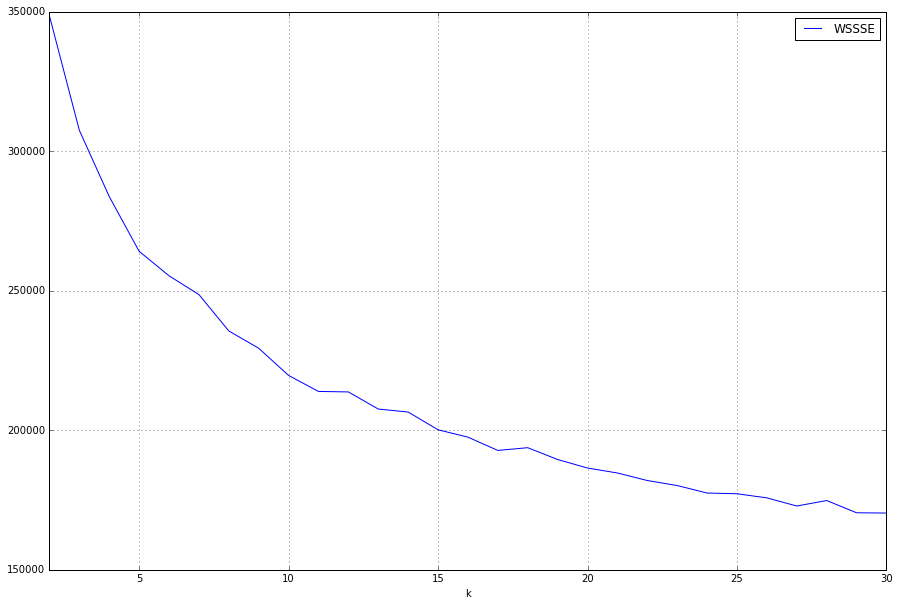

In [63]:
wssseDF = pd.DataFrame({'WSSSE' : wssseList, 'k' : range(2,31) })
wssseDF.plot(y='WSSSE', x='k', figsize=(15,10), grid=True)

# Clustering on entire dataset

In [16]:
# Once ELBOW is performed on downsampled dataset, let us run k-means on FULL data set

#Get Full Dataset
full 	= dataDF
#How big is the this dataset ?
full.count()

1587257

In [32]:
#Drop rows with missing fields
fullDF 	= full.select(cols).na.drop()
#How many rows did we drop ?
fullDF.count()

1586824

In [33]:
#CONVERT Speed from meters/sec to miles per hour
fullDF 	= fullDF.withColumn('avg_wind_speed', fullDF.avg_wind_speed * 2.236)
fullDF 	= fullDF.withColumn('max_wind_speed', fullDF.max_wind_speed * 2.236)

#ASSEMBLE all the features into one column
fullAssembled 	= assembler.transform(fullDF)

#SCALE the dataset column 'features'.
scalerFullModel	= scaler.fit(fullAssembled)
scaledFullData 	= scalerFullModel.transform(fullAssembled)

#SELECT the features column and persist the dataframe
scaledFullData 	= scaledFullData.select("features")
scaledFullData.persist()

DataFrame[features: vector]

In [35]:
# Review the graph above and run k-means for a specific k :
kmeans			= KMeans(k=11, seed = 1)
model			= kmeans.fit(scaledFullData)
transformed		= model.transform(scaledFullData)
featuresAndPrediction	= transformed.select("features", "prediction")
errorWSSSE		= computeCost(featuresAndPrediction, model)
print(errorWSSSE)

2176904.47438


In [36]:
#How many members per clusters
import pyspark.sql.functions as func

featuresAndPrediction.groupby(featuresAndPrediction.prediction).agg(func.count('prediction')).show()

+----------+-----------------+
|prediction|count(prediction)|
+----------+-----------------+
|         0|           194305|
|         1|           268653|
|         2|           139190|
|         3|            46260|
|         4|           165531|
|         5|            98646|
|         6|           134739|
|         7|           218817|
|         8|           103182|
|         9|           151954|
|        10|            65547|
+----------+-----------------+



In [37]:
from pandas.tools.plotting import parallel_coordinates
import numpy as np

In [38]:
colNames = ['air_pressure','air_temp','avg_wind_direction','avg_wind_speed',
'max_wind_direction','max_wind_speed','relative_humidity', 'prediction']

In [39]:
# Get the cluster centers
C = model.clusterCenters()

# Zip with a column called 'prediction' (index)
Z = [np.append(A, index) for index, A in enumerate(C)]

# Convert to pandas for plotting
P = pd.DataFrame(Z, columns=colNames)
P['prediction'] = P['prediction'].astype(int)

In [44]:
P

,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,relative_humidity,prediction
0,-0.004687,0.699587,0.414523,0.426162,0.528089,0.385184,-0.264520,0
1,0.393102,0.586472,-1.281209,-0.466651,-1.137944,-0.471419,-0.826856,1
2,0.076304,-0.692853,-1.206120,-0.550541,-1.059591,-0.567700,0.770429,2
3,-1.548529,-1.419511,0.386325,2.251262,0.493777,2.219539,1.502907,3
4,0.238064,-0.968609,0.629296,-0.551844,0.817998,-0.536381,1.124242,4
5,-0.787569,-0.128662,0.446377,1.572075,0.529115,1.498585,0.246677,5
6,0.331329,0.745599,1.294204,-0.653199,1.556855,-0.608333,-0.746625,6
7,-0.333035,0.569264,0.130000,-0.698217,0.310552,-0.710859,-0.379277,7
8,1.297904,-0.239471,-1.154774,1.761433,-1.050014,1.870008,-1.125873,8
9,-0.850115,-1.188582,0.380447,0.370369,0.474192,0.358627,1.360249,9


## Plots

## Dry Days

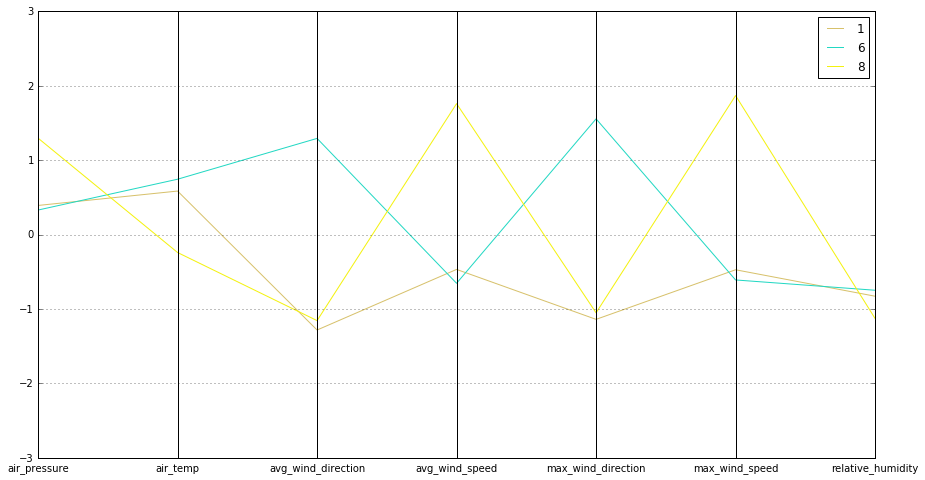

In [45]:
# Parallel Coordinates Plot 1: Dry Days (Low Humidity)
plt.figure(figsize=(15,8)).gca().axes.set_ylim([-3,+3])
parallel_coordinates(P[P['relative_humidity']< -0.5], 'prediction')

## Warm Days

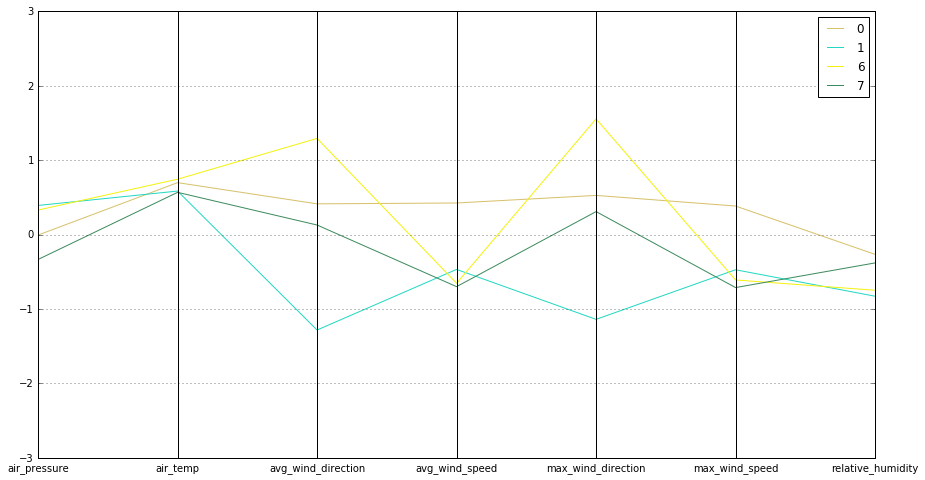

In [46]:
# Parallel Coordinates Plot 1: Warm Days (High Temperature)
plt.figure(figsize=(15,8)).gca().axes.set_ylim([-3,+3])
parallel_coordinates(P[P['air_temp']> 0.5], 'prediction')

## Cool and Rainy Days

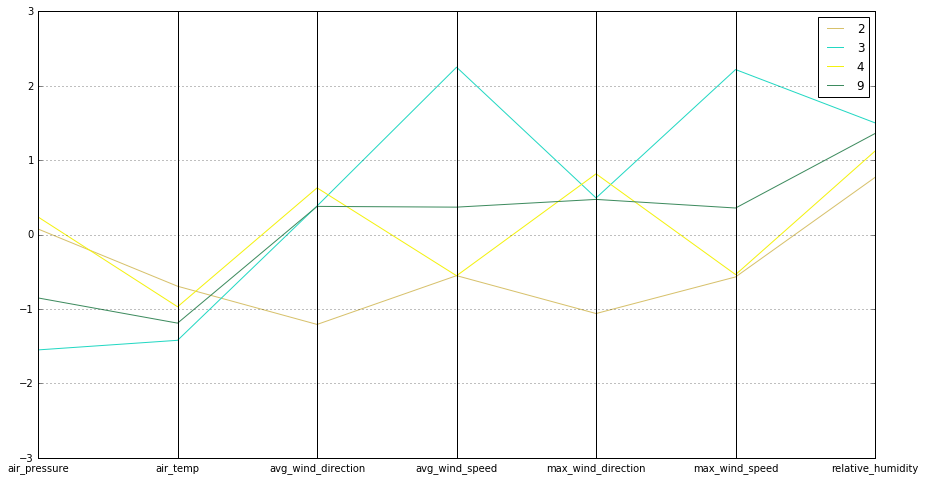

In [48]:
# Parallel Coordinates Plot 1: Cool and Possibily Rainy Days (High Humidity, Low Temp)
plt.figure(figsize=(15,8)).gca().axes.set_ylim([-3,+3])
parallel_coordinates(P[(P['relative_humidity']>0.5) & (P['air_temp']< 0.5)], 'prediction')

## Other Days

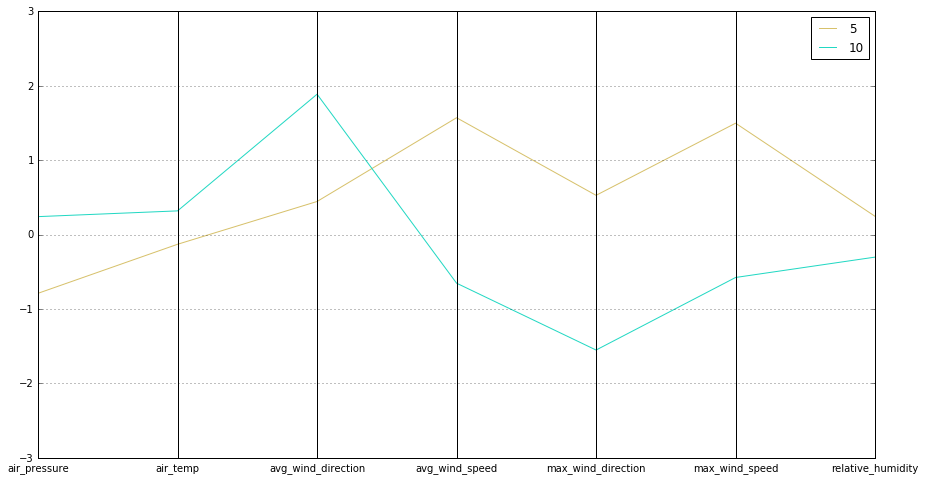

In [54]:
# Parallel Coordinates Plot 1: Dry Days (Low Humidity)
plt.figure(figsize=(15,8)).gca().axes.set_ylim([-3,+3])

parallel_coordinates(P.iloc[[5,10]], 'prediction')